This week, to try and find inspiration for a short, or at least quick, blog post, I did an “AI Search” and asked for some frequently un-answered RDKit questions. One of those was related to understanding stereochemistry. Then, this morning, I noticed a question in GitHub Discussions asking why the chirality on a tertiary amine wasn’t being preserved. My post topic was clear!

The contents of this post will end up, in an edited form, in the [RDKit Book](https://www.rdkit.org/docs/RDKit_Book.html)

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,250

# Intro
In this post I am going to focus solely on stereochemistry/chirality around tetrahedral atoms. I am aware that there are non-tetrahedral forms of stereochemistry for three- and four-coordinate atoms (and the RDKit supports some of them). Non-tetrahedral stereochemistry, double-bond stereochemistry, and atropisomerism are topics for a possible future post. 

# What can be chiral?

I will borrow the language used in the [InChI technical manual](https://www.inchi-trust.org/download/104/InChI_TechMan.pdf) and use the term “stereogenic” to refer to atoms which can be chiral if all of their substituents are different. The RDKit uses the same conditions to determine which atoms can be involved in ring stereochemistry (see below).

If you ever want to go straight to the source to see what could be a potential stereocenter, the function to look for is [isAtomPotentialChiralCenter()]() .

In general, the following conditions have to be met for an atom to be considered a potential stereocenter:
- It must have a total nonzero-degree of three or four. I.e. three or four neighbors not connected via zero-order bonds.
- It cannot have two attached hydrogen atoms (explicit or implicit). For the purposes of this count, only H atoms with unspecified isotopes count.
- Three coordinate atoms cannot have an H atom attached, except for phosphines, arsines, S and Se with an explicit valence of four, and S+ and Se+ with an explicit valence of three.
- Degree three N atoms cannot have an H atom attached and must be involved in either a three-membered ring or be a bridgehead

Because arbitrary decisions have to be made when dealing with this topic - for example, are tertiary amines stereogenic? - we choose to (try and) follow InChI and use Table 8 from the [InChI technical manual](https://www.inchi-trust.org/download/104/InChI_TechMan.pdf) here. If an element is not present in that InChI table, we use the general rules above. One notable exception for main-group atoms is that the RDKit allows trivalent N atoms that are in a bridgehead to be chiral centers. 

An example chiral phosphine (invented):

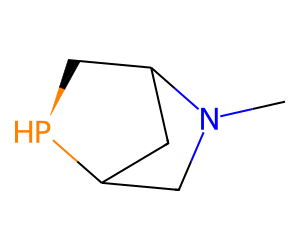

In [21]:
Chem.MolFromSmiles('C12C[N@](C)C(C2)C[P@H]1')

> That really should have the `[H]` drawn as a separate atom

Notice that, though the chirality on the N was specified in the input, it was removed when the molecule was parsed: the N is neither in a three-membered ring nor a bridgehead.

Here's an example of a ChEMBL molecule with a chiral bridgehead N:

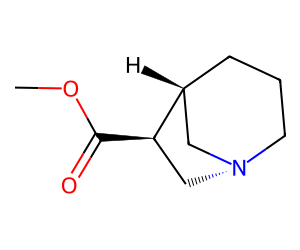

In [15]:
Chem.MolFromSmiles('COC(=O)[C@@H]1C[N@@]2CCC[C@@H]1C2')

# The RDKit's representation of atomic stereochemistry

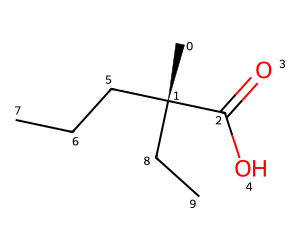

In [11]:
IPythonConsole.drawOptions.addAtomIndices = True
m = Chem.MolFromSmiles('C[C@](C(=O)O)(CCC)CC')
m

We can see the internal representation in the output of `Debug()` for the chiral center, atom 1:

In [12]:
m.Debug()

Atoms:
	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	1 6 C chg: 0  deg: 4 exp: 4 imp: 0 hyb: SP3 chi: CCW nbrs:[0 2 5 8]
	2 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: SP2
	3 8 O chg: 0  deg: 1 exp: 2 imp: 0 hyb: SP2
	4 8 O chg: 0  deg: 1 exp: 1 imp: 1 hyb: SP2
	5 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
	6 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
	7 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
	8 6 C chg: 0  deg: 2 exp: 2 imp: 2 hyb: SP3
	9 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: SP3
Bonds:
	0 0->1 order: 1
	1 1->2 order: 1
	2 2->3 order: 2 conj?: 1
	3 2->4 order: 1 conj?: 1
	4 1->5 order: 1
	5 5->6 order: 1
	6 6->7 order: 1
	7 1->8 order: 1
	8 8->9 order: 1


The important information here is `chi` and `nbrs`, which tell us that if we look from atom 0 to atom 1, we need to rotate counter-clockwise to go from atom 2 to atom 5 (or from atom 5 to atom 8).